In [24]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = int(3.4*24000)
        self.scaling = scaling
        self.data = self.createData(hdf)
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

hdf = h5py.File('../../../test_24k.hdf5', 'r')
print(hdf.keys())
print(hdf[list(hdf.keys())[0]].keys())
dataset = SnippetDatasetHDF(hdf)
hdf.close()



<KeysViewHDF5 ['0008f100-b3dd-42b4-bdf8-b49a87fe2d6d', '001f38c5-3f83-4c99-8487-8fa6b1e02d9c', '00363dfa-be74-4244-b2a7-4c3fbb6e3c12', '003d096a-0762-4a40-a5bd-f82a0d7ce093', '0059a3f3-483e-4632-b295-cc63d2e29b6a', '005c78b7-88aa-460e-a751-c6ebff5cf2ab', '00692830-8597-419c-9849-2c60d12d4df6', '00857f80-2437-4200-82ab-5202061b03c3', '008e80ba-ff81-4517-a2ad-7a7359204e83', '0099bcd9-f153-422d-a4ab-6daf330d419a', '009dfc8a-7ba3-478a-8407-cca04d5b6356', '009fca68-0c8a-4ed0-9d83-ebd5196c9b52', '00a2d887-398d-46e7-a0f3-2a2f7b0c281b', '00ac04f0-d565-49d8-8301-d57bc1b62ba6', '00af0bb4-2e91-4159-86e8-c586fc2d07d2', '00b4fa8f-b724-4d24-92ae-5249d819844e', '00bfbcaf-5595-4fca-b2e5-3e94af81c805', '00cb42bf-b5ee-4ae5-8f8e-d30060bb5f03', '00d957b6-6d7c-47dd-ae91-264d4072551e', '00e72037-0279-432a-abdd-6a37d2a66ceb', '0123461b-0bf8-4064-bd52-cde721a884a5', '01365a6d-6fc3-419e-b26c-1e56b34ae8f3', '014ac4dc-172e-4dbe-94f0-fee88bc67ddb', '015678be-0312-4244-9574-3cfcc66d6dd6', '01586ca9-de5a-4a33-abb2-

  0%|          | 0/6675 [00:00<?, ?it/s]

100%|██████████| 6675/6675 [00:05<00:00, 1220.20it/s]


In [2]:
from encodec import EncodecModel
from encodec.utils import convert_audio

import dac
from audiotools import AudioSignal
import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)

dac_model_path = dac.utils.download(model_type='24kHz')
dac_model = dac.DAC.load(dac_model_path)

# Load and pre-process the audio waveform
signal = AudioSignal(dataset.retransform(dataset[0]),sample_rate=24000)
wav = convert_audio(signal.audio_data, signal.sample_rate, model.sample_rate, model.channels)

wav_dac = dac_model.preprocess(signal.audio_data, signal.sample_rate)
z, codes, latents,_,_ = dac_model.encode(wav_dac)
latents = torch.nn.functional.pad(latents, (0, 1))

from_latent_dac,_,_ = dac_model.quantizer.from_latents(latents)
rebuild_dac = dac_model.decode(from_latent_dac)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]

/home/npopkov/dll24/.conda/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
emb = model.quantizer.decode(codes)

In [4]:
latents.shape

torch.Size([1, 256, 256])

In [5]:
rebuild_dac.shape

torch.Size([1, 1, 81912])

In [6]:
float_codes = codes.float()
float_codes

tensor([[[103.,  25., 103.,  ...,  62.,  62.,  62.],
         [529.,   5., 549.,  ..., 518., 518., 518.],
         [218., 823., 155.,  ..., 786., 786., 786.],
         ...,
         [348., 225., 519.,  ..., 986., 986., 986.],
         [407., 401., 606.,  ..., 900., 900., 900.],
         [235., 412., 412.,  ..., 518., 518., 518.]]])

In [7]:
test = model.encoder(wav)

In [8]:
test.shape

torch.Size([1, 128, 255])

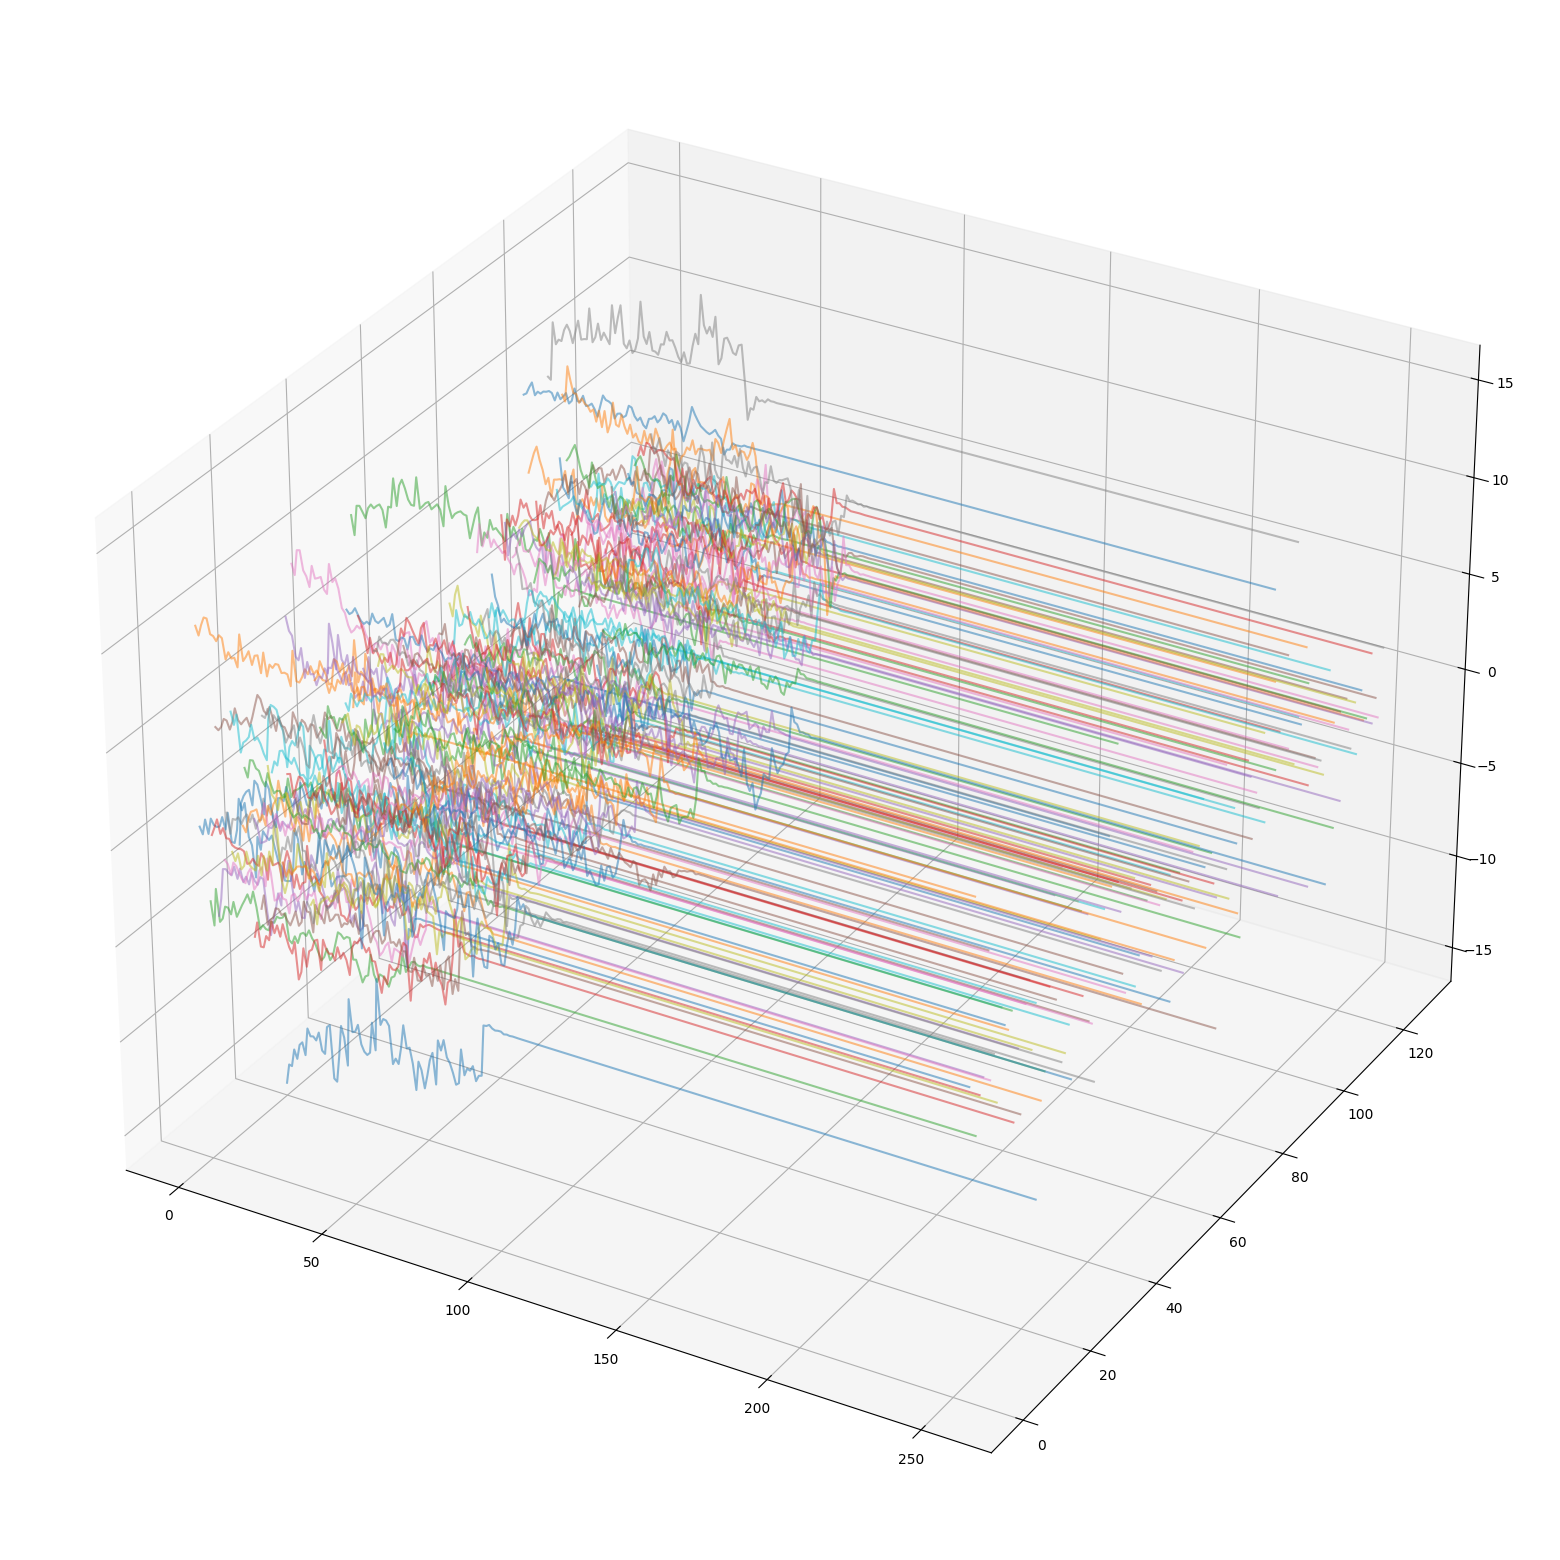

In [9]:
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np


ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')
for i in range(0,128):
    ax.plot(np.arange(0,255),test.squeeze().detach().numpy()[i],zs=i,zdir='y',alpha=0.5)

In [10]:
encoded_frames[0][0].shape

torch.Size([1, 8, 255])

In [11]:
print(encoded_frames[0][1])

None


(-0.5, 254.5, -0.5, 127.5)

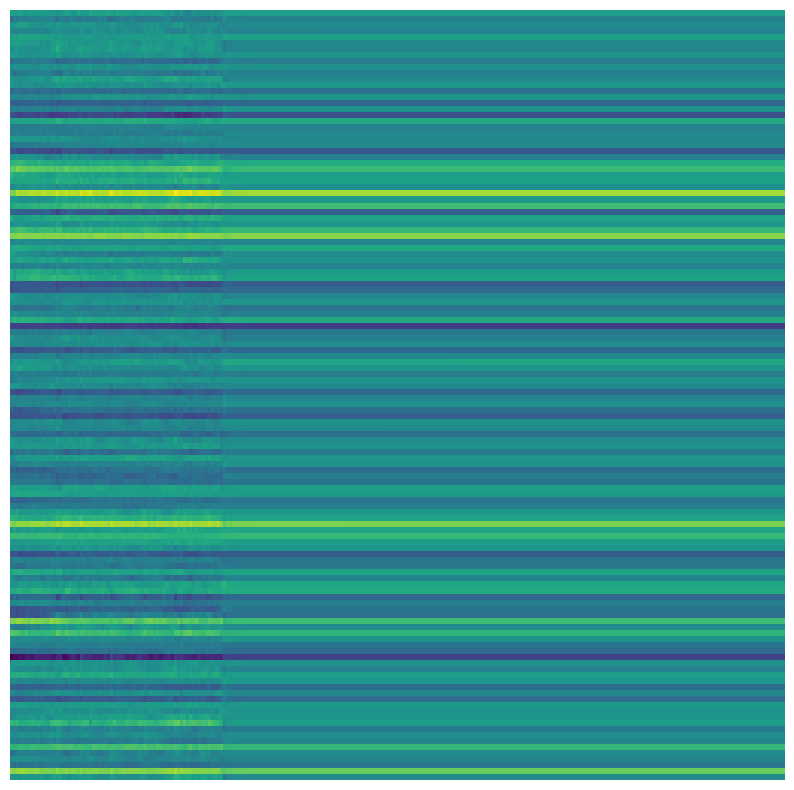

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(test.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower')
plt.axis('off')

In [13]:
rebuild = model.decode(encoded_frames)

(0.0, 24000.0, -0.1, 0.1)

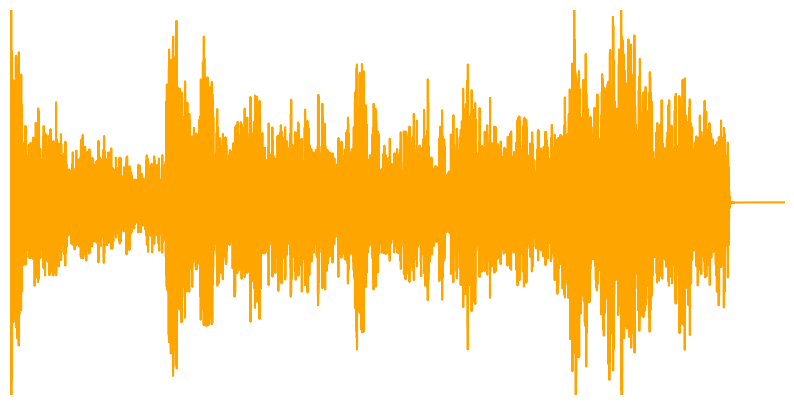

In [14]:
plt.figure(figsize=(10, 5))
#plt.plot(signal.audio_data.squeeze(), label='original',color='teal')
plt.plot(rebuild_dac.squeeze().detach().cpu().numpy(), label='rebuild',color='orange')
plt.xlim(0, 24000)
plt.ylim(-.1, .1)
plt.xticks([])
plt.grid()
#plt.legend()
plt.axis('off')

In [20]:
generated = torch.load('/home/npopkov/dll24/models/ddpm/sample.pt')
generated = generated[:,:,:,:-1]
print(generated.shape)
gen_z,_,_ = dac_model.quantizer.from_latents(generated[4].cpu())
rebuild_generated = dac_model.decode(gen_z)
rebuild_generated = rebuild_generated


torch.Size([6, 1, 256, 255])


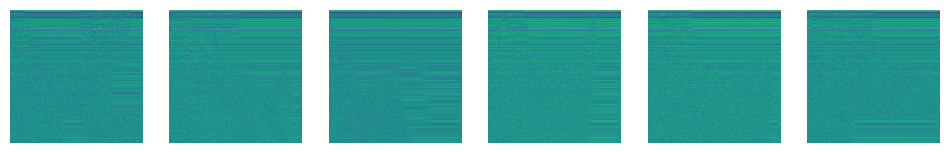

In [18]:
fig , ax = plt.subplots(1,6,figsize=(12, 10))
for i in range(6):
    ax[i].imshow(generated[i].squeeze().detach().cpu().numpy())
    ax[i].axis('off')
plt.show()


In [21]:
from IPython.display import Audio
Audio(rebuild_generated.detach().squeeze().numpy(), rate=24000)
#save audio
#sf.write('rebuild_generated.wav', rebuild_generated.detach().squeeze().numpy(), 24000)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x70e5d57cbd60>>
Traceback (most recent call last):
  File "/home/npopkov/dll24/.conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x70e5d57cbd60>>
Traceback (most recent call last):
  File "/home/npopkov/dll24/.conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


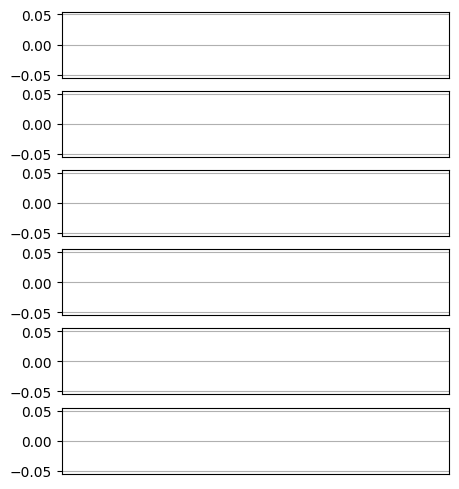

In [22]:
fig, ax = plt.subplots(6, 1, figsize=(5, 6))

for i,gen in enumerate(generated):
    gen_z,_,_ = dac_model.quantizer.from_latents(gen.cpu())
    rebuild_generated = dac_model.decode(gen_z)
    rebuild_generated = rebuild_generated
    ax[i].plot(rebuild_generated.squeeze().detach().cpu().numpy(), label='rebuild',color='orange')
    ax[i].grid()
    ax[i].xaxis.set_visible(False)
plt.show()



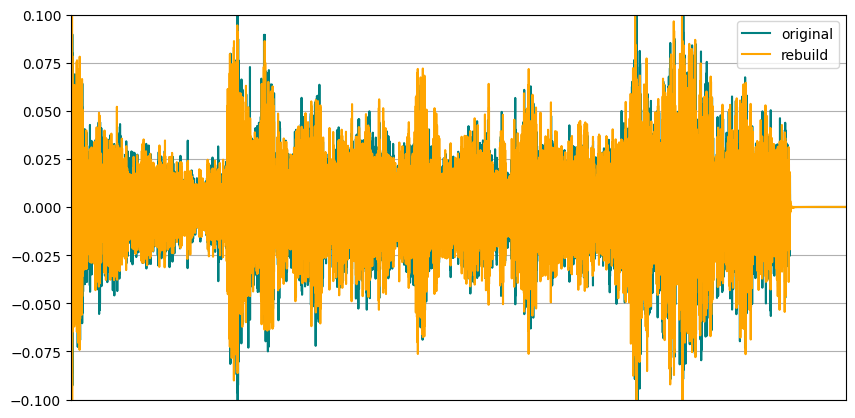

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(signal.audio_data.squeeze(), label='original',color='teal')
plt.plot(rebuild_dac.squeeze().detach().cpu().numpy(), label='rebuild',color='orange')
plt.xlim(0, 24000)
plt.ylim(-.1, .1)
plt.xticks([])
plt.grid()
plt.legend()

In [20]:


# Download a model
#model_path = dac.utils.download(model_type="24kHz")
#model = dac.DAC.load(model_path)
#
#model.to('cuda')



In [21]:
import librosa
from IPython.display import Audio
import soundfile as sf

In [22]:
Audio(dataset[0],rate=24000)

In [23]:
# Load audio signal file
def try_and_plot(i):
    signal = AudioSignal(dataset[i],sample_rate=24000)

    # Encode audio signal as one long file
    # (may run out of GPU memory on long files)
    signal.to('cuda')

    x = model.preprocess(signal.audio_data, sigsf.write('rebuild_generated.wav', rebuild_generated.detach().squeeze().numpy(), 24000)nal.sample_rate).to('cuda')
    z, codes, latents, _, _ = model.encode(x)
    # Decode audio signal
    y = model.decode(z)
    plt.imshow(z.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')



SyntaxError: invalid syntax (2603993267.py, line 9)

In [ ]:
#signal = AudioSignal(dataset[3],sample_rate=24000)

# Encode audio signal as one long file
# (may run out of GPU memory on long files)
#signal.to('cuda')

#x = model.preprocess(signal.audio_data, signal.sample_rate).to('cuda')
#z, codes, latents, _, _ = model.encode(x)

In [ ]:

#latents = torch.nn.functional.pad(latents, (0, 1))
#print(latents.shape)

#plt.imshow(latents.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')

In [ ]:
#test,_,_ = model.quantizer.from_latents(latents)

In [ ]:
#y = model.decode(test)
#print(y.shape)
#Audio(y.squeeze().cpu().detach().numpy(),rate=24000)

In [ ]:
#import h5py

# Create a new HDF file
#output_file = 'encoded_samples.hdf5'
#hdf_output = h5py.File(output_file, 'w')

# Encode and store each sample in the HDF file
#for i in tqdm(range(len(dataset))):
#    sample = dataset[i]
#    signal = AudioSignal(sample, sample_rate=24000)
#    signal.to('cuda')
#    x = model.encode(signal.audio_data, signal.sample_rate).to('cuda')
#    z, _, latents, _, _ = model.encode(x)
#    latents = torch.nn.functional.pad(latents, (0, 1))
#    hdf_output.create_dataset(f'sample_{i}', data=latents.squeeze().detach().cpu().numpy())

# Close the HDF file
#hdf_output.close()

# Print the path of the output file
#print(f"Encoded samples saved to: {output_file}")

In [ ]:
#hdf_output.close()


In [ ]:
import h5py

# Create a new HDF file
output_file = 'encoded_samples.hdf5'
hdf_output = h5py.File(output_file, 'w')

# Encode and store each sample in the HDF file
for i in tqdm(range(len(dataset))):
    sample = dataset[i]
    signal = AudioSignal(sample, sample_rate=24000)
    wav = convert_audio(signal.audio_data, signal.sample_rate, model.sample_rate, model.channels)
    # Extract discrete codes from EnCodec
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)
    hdf_output.create_dataset(f'sample_{i}', data=codes.squeeze().detach().cpu().numpy())

# Close the HDF file
hdf_output.close()

# Print the path of the output file
print(f"Encoded samples saved to: {output_file}")

  2%|▏         | 95/5756 [00:03<03:25, 27.51it/s]


KeyboardInterrupt: 